# This script demonstrates how to optimize a variational autoencoder similar to talos

Since talos does no longer support tf2.0, and also suffer from some other aspects, it is better to do a grid search manually.

In [1]:
# VAE
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()

# DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.datasets import mnist

# Math
import numpy as np
from scipy.stats import norm
from itertools import product

# Plot
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import astetik
%matplotlib inline

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.2
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


## File dump location

In [ ]:
dump_loc = '/tmp/vae_tools_mnist/'

In [2]:
# Get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Cut down data set for testing
#x_train = x_train[:10,:]
#y_train = y_train[:10]
#x_test = x_test[:10,:]
#y_test = y_test[:10]

In [3]:
# Define the network and parameter structure

# p = {'lr': [10., 1, 0.1],
#      'intermediate_dim': [64, 128],
#      'activation':['elu'],
#      'batch_size': [64, 128],
#      'epochs': [20, 40],
#      'optimizer': [Adam, Nadam, RMSprop],
#      'beta': [1.0],
#      'reconstruction_loss_metrics': [ReconstructionLoss.MSE],
#      'z_dim': [2, 4]}

p = {'lr': [1],
     'intermediate_dim': [64, 128, 256],
     'activation':['relu', 'elu'],
     'batch_size': [1024, 2048],
     'epochs': [10, 20],
     'optimizer': [Adam, RMSprop],
     'beta': [0.01, 1.0],
     'reconstruction_loss_metrics': [ReconstructionLoss.MSE],
     'z_dim': [2]}
# p = {'lr': [1],
#      'intermediate_dim': [64, 128, 256],
#      'activation':['elu'],
#      'batch_size': [1024],
#      'epochs': [2],
#      'optimizer': [Adam],
#      'beta': [1.0],
#      'reconstruction_loss_metrics': [ReconstructionLoss.MSE],
#      'z_dim': [2]}

img_rows, img_cols, img_chns = 28, 28, 1
original_dim = img_rows * img_cols * img_chns
def hp_process(x_train, y_train, x_val, y_val, params):
    # resetting the layer name generation counter
    tf.keras.backend.clear_session()
    # Build the model and train it
    vae_tools.sampling.set_seed(0)
    encoder = [[
        Input(shape=(original_dim,), name="in"),
        Dense(params['intermediate_dim'], activation=params['activation'], name="in_d1"),
        Dense(int(params['intermediate_dim']/2), activation=params['activation'], name="in_d2")
    ]]

    decoder = [[
        Dense(int(params['intermediate_dim']/2), activation=params['activation'], name="out_d2"),
        Dense(params['intermediate_dim'], activation=params['activation'], name="out_d1"),
        Dense(original_dim, activation='sigmoid', name="out")
    ]]

    vae_obj = MmVae(params['z_dim'], encoder, decoder, [original_dim], params['beta'],
                    reconstruction_loss_metrics = [params['reconstruction_loss_metrics']], name='Vae')

    vae_model = vae_obj.get_model()
    vae_model.compile(optimizer=params['optimizer'](vae_tools.sanity.lr_normalizer(params['lr'], params['optimizer'])), loss=None)
    h = vae_model.fit(x_train, shuffle=True, epochs=params['epochs'], batch_size=params['batch_size'], verbose = 2, validation_data=(x_val, None))

    # Store the final models
    vae_obj.store_model_powerset(dump_loc + 'enc_mean_' + str(params['index']) + '_a_', vae_obj.encoder_inputs, vae_obj.get_encoder_mean)
    vae_obj.store_model_powerset(dump_loc + 'enc_logvar_' + str(params['index']) + '_a_', vae_obj.encoder_inputs, vae_obj.get_encoder_logvar)
    vae_obj.get_decoder().save("/tmp/a/dec_" + str(params['index']) + "_a.h5")

    return h.history.copy()

## Hyperparameter (hp) search

In [4]:
# Get all combinations of hp
hp = [dict(zip(p, v)) for v in product(*p.values())]
# add an index to the hyperparameters
for h, idx in zip(hp, list(range(len(hp)))):
    h.update({'index': idx})

hp_h = [] # list of histories

# Perform grid search
for params in hp:
    h = hp_process(x_train, y_train, x_test, y_test, params)
    hp_h.append(h)


[{'epochs': 10, 'z_dim': 2, 'lr': 1, 'reconstruction_loss_metrics': 'MSE', 'beta': 0.01, 'intermediate_dim': 64, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'activation': 'relu', 'batch_size': 1024, 'index': 0}, {'epochs': 10, 'z_dim': 2, 'lr': 1, 'reconstruction_loss_metrics': 'MSE', 'beta': 0.01, 'intermediate_dim': 64, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'activation': 'relu', 'batch_size': 2048, 'index': 1}, {'epochs': 10, 'z_dim': 2, 'lr': 1, 'reconstruction_loss_metrics': 'MSE', 'beta': 0.01, 'intermediate_dim': 128, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'activation': 'relu', 'batch_size': 1024, 'index': 2}, {'epochs': 10, 'z_dim': 2, 'lr': 1, 'reconstruction_loss_metrics': 'MSE', 'beta': 0.01, 'intermediate_dim': 128, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'activation': 'relu', 'batch_size': 2048, 'index': 3}, {'epochs': 10, 'z_dim': 2, 'lr': 1, 'reconstr

## Create a pandas dataframe (df) and store it

In [ ]:
# Store just everything into a folder

data = {}

# Prefixes for history and for the full history as a list
h_prefix = 'h_'
h_list_prefix = 'list_'

# init hp keys
for k in hp[0].keys():
    data[k] = []
# write hp keys
for params in hp:
    for k in params.keys():
        data[k].append(params[k])

# init history keys
for k in hp_h[0].keys():
    data[h_prefix + k] = []
    data[h_prefix + h_list_prefix + k] = []
# write history keys
for h in hp_h:
    for k in h.keys():
        data[h_prefix + h_list_prefix + k].append(h[k])
# write final history keys
for h in hp_h:
    for k in h.keys():
        data[h_prefix + k].append(h[k][-1])

# Create pandas dataframe and store it
df = pd.DataFrame(data)
df.to_hdf(dump_loc + 'history.h5', key='df')

# Print the output.
df

## Some plot magic

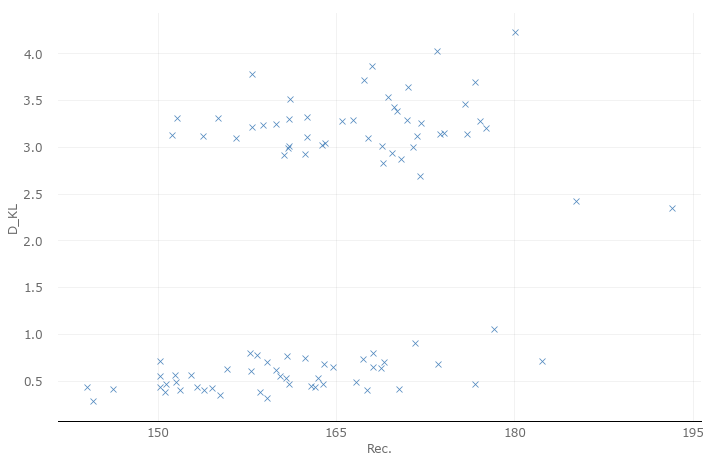

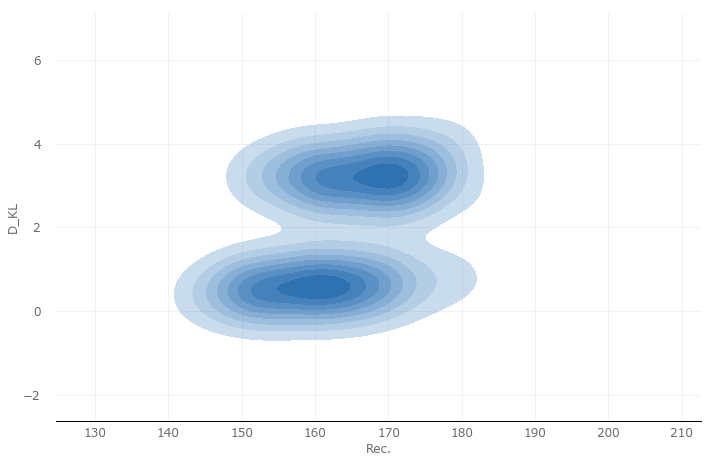

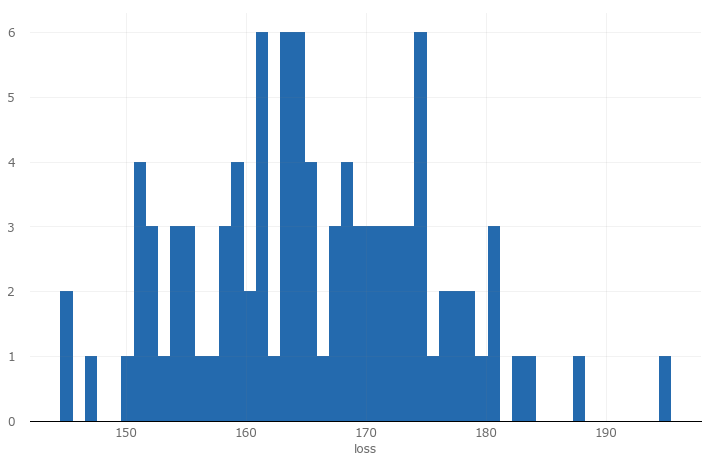

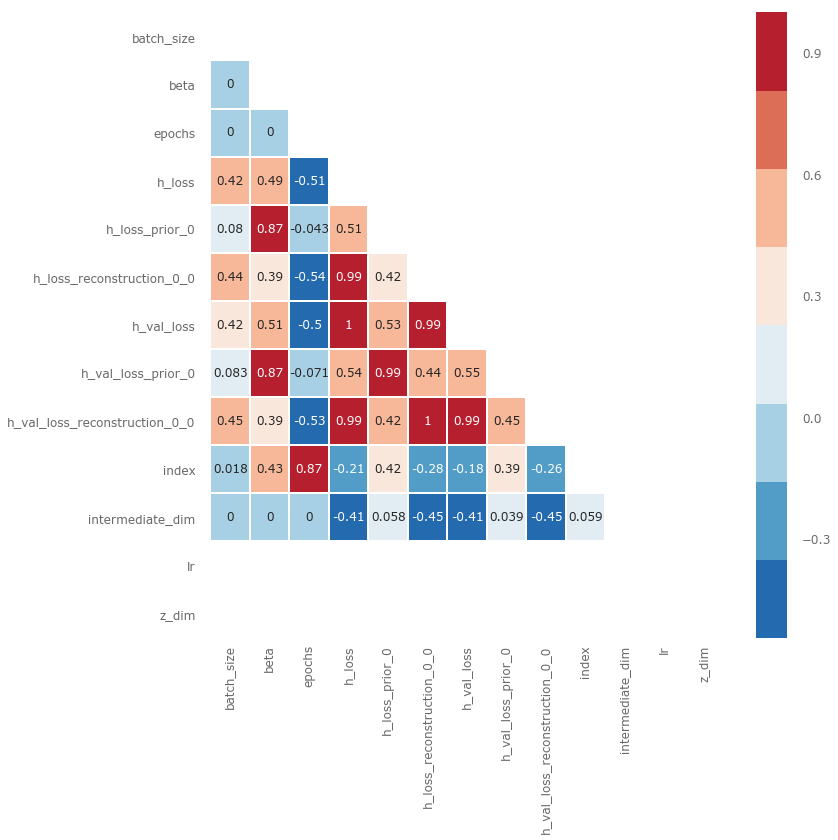

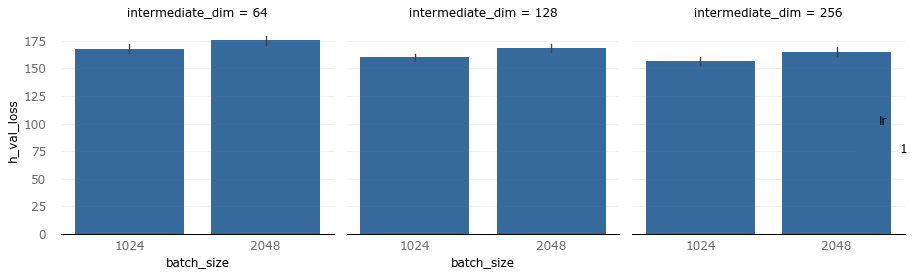

In [11]:
# a regression plot for two dimensions 
astetik.regs(df, x=h_prefix + 'val_loss_reconstruction_0_0', y=h_prefix + 'val_loss_prior_0', x_label='Rec.', y_label='D_KL')
# up to two dimensional kernel density estimator
astetik.kde(df, x=h_prefix + 'val_loss_reconstruction_0_0', y=h_prefix + 'val_loss_prior_0', x_label='Rec.', y_label='D_KL')
# a simple histogram
astetik.hist(df, h_prefix + 'val_loss',bins=50, x_label='loss')
# correlation
astetik.corr(df.drop(["activation","reconstruction_loss_metrics","optimizer"], axis=1), color_grades=5, style='astetik', annot=True)
# a four dimensional bar grid
astetik.bargrid(df, x='batch_size', y=h_prefix + 'val_loss', hue='lr', col='intermediate_dim',  col_wrap=3)

## Get the 5 best results according to the desired metric

In [12]:
def sort_params(r, metric=h_prefix + 'val_loss_reconstruction_0_0', ascending=True):
    ''' Sort table 'r' (pandas DataFrame) wrt. 'metric'
    '''
    out = r.sort_values(metric, ascending=ascending)
    try:
        out = out.drop(None, axis=1)
    finally:
        return out
out = sort_params(df, metric=h_prefix + 'val_loss_reconstruction_0_0') # losslayer_distribution_gaussian_prior, losslayer_reconstruction_mse
best_of = 5
out.head(best_of).style

## Print the latent spaces of the results of the best results

Loaded model /tmp/a/enc_mean_58_a_1 from disk
Loaded model /tmp/a/enc_mean_52_a_1 from disk
Loaded model /tmp/a/enc_mean_50_a_1 from disk
Loaded model /tmp/a/enc_mean_53_a_1 from disk
Loaded model /tmp/a/enc_mean_70_a_1 from disk


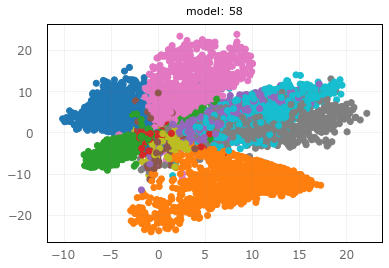

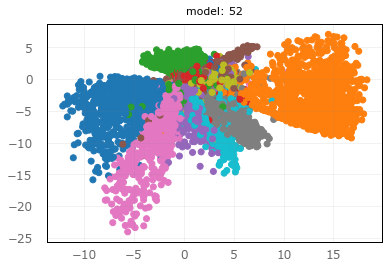

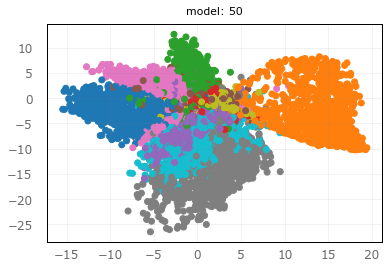

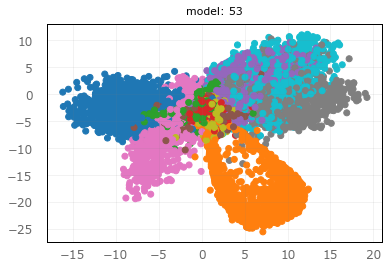

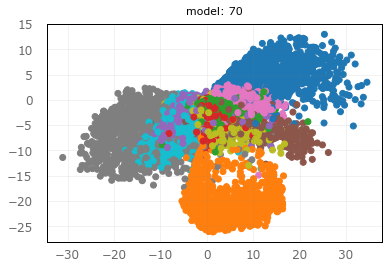

In [8]:
for idx in range(min(len(out),best_of)):
    # get model index
    index = out['index'].values[idx]
    model_prefix_name = dump_loc + 'enc_mean_' + str(index) + '_a_'
    models, _ = vae_tools.vae.GenericVae.load_model_powerset(model_prefix_name, num_elements = 1)
    print(models)
    v = models[0].predict(x_test)
    plt.scatter(v[:,0], v[:,1], c=y_test, cmap='tab10')
    plt.title("model: " + str(index))
    plt.show()
